<a href="https://colab.research.google.com/github/skywalker0803r/deep-learning-ian-goodfellow/blob/master/reinforce/PPO_GAE_UNDO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.distributions import Categorical
from torch import optim
from torch import nn
torch.set_grad_enabled(True)  # Context-manager 
from collections import deque
import numpy as np
import random
import warnings 
import gym
warnings.simplefilter('ignore')
seed = 6
torch.manual_seed(seed)

device = 'cuda:0'

def compute_gae_lambda_advantages(rewards, values, done, gamma=0.99 ,lambda_=0.99):
  advantages = torch.zeros_like(rewards)
  advantage = 0
  done[done==0] = 2
  done[done==1] = 0
  done[done==2] = 1
  for i in reversed(range(len(rewards)-1)):
    delta = rewards[i] + gamma * values[i+1] * done[i] - values[i]
    advantage = delta + gamma * lambda_ * advantage * done[i]
    advantages[i] = advantage
  return advantages

def List2Tensor(x):    
  x = np.array([i for i in x]).ravel()
  x = torch.FloatTensor(x).to(device).view(-1, 1)
  return x

# model
class critic(nn.Module):
    ''' 
    input : state
    output : state_value(scalar)
    '''
    def __init__(self, input_dim):
        super(critic, self).__init__()
        self.fc1 = nn.Linear(input_dim,128)
        self.fc2 = nn.Linear(128,128)
        self.fc3 = nn.Linear(128,1)

    def forward(self,state):
        state = F.relu(self.fc1(state))
        state = F.relu(self.fc2(state))
        
        # Linear output
        return self.fc3(state)

class actor(nn.Module):
    '''
    input : state 
    output : action_probs(vector)
    '''
    def __init__(self, input_dim, output_dim):
        super(actor, self).__init__()
        self.fc1 = nn.Linear(input_dim,128)
        self.fc2 = nn.Linear(128,128)
        self.fc3 = nn.Linear(128,output_dim)
    
    def forward(self, state):
        logits = F.relu(self.fc1(state))
        logits = F.relu(self.fc2(logits))
        
        # softmax output
        return F.softmax(self.fc3(logits),dim=1)
#agent
class PPO_GAE_Agent(object):
    def __init__(self,env,gamma = 0.99,
                 clip = 0.2,
                 lr = 1e-3,
                 K_epoch = 4,
                 lam = 0.95):
        
        # common
        self.device = "cuda:0"
        self.env = env
        self.obs_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n
        
        # Hyperparamters
        self.gamma = gamma
        self.clip = clip
        self.lr = lr
        self.K_epoch = K_epoch
        self.lam = lam
        
        # critic
        self.critic = critic(self.obs_dim).to(self.device)
        self.critic.apply(self._weights_init)
        
        # actor_new
        self.actor_new = actor(self.obs_dim,self.action_dim).to(self.device)
        self.actor_new.apply(self._weights_init)
        
        # actor_old,sync
        self.actor_old = actor(self.obs_dim,self.action_dim).to(self.device)
        self.sync()
        
        # optimizer
        self.critic_optimizer = optim.Adam(self.critic.parameters(),lr=lr)
        self.actor_optimizer = optim.Adam(self.actor_new.parameters(),lr=lr)
        
        # recorder
        self.recorder = {'a_loss':[],
                         'v_loss':[],
                         'e_loss':[],
                         'ratio':[]}
            
    @staticmethod
    def _weights_init(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0.1)
    
    def sync(self):
        for old_param, new_param in zip(self.actor_old.parameters(),self.actor_new.parameters()):
            old_param.data.copy_(new_param.data)
    
    def get_action(self,state):
        state = torch.FloatTensor([state]).to(self.device)
        probs = self.actor_new(state) # softmax_probs
        dist = Categorical(probs) # Categorical distribution
        act = dist.sample() # smaple action from this Categorical distribution
        return act.detach().item()
    
    def get_value(self,state):
        state = torch.FloatTensor([state]).to(self.device)
        value = self.critic(state)
        return value.item()
    
    def compute_returns(self,rewards):
        returns = []
        G = 0
        
        for r in rewards[::-1]:
            G = r + self.gamma*G
            returns.insert(0,G)
        
        returns = np.array([i for i in returns]).ravel()
        
        return torch.FloatTensor(returns).to(self.device).view(-1, 1)

    def normalize(self,x):
      try:
        return (x - x.mean()) / x.std()
      except:
        x = np.array(x)
        return (x - x.mean()) / x.std()
    
    def update(self,trajectory):
        
        # get trajectory
        state = torch.FloatTensor([sars[0] for sars in trajectory]).to(self.device)
        action = torch.LongTensor([sars[1] for sars in trajectory]).to(self.device).view(-1, 1)
        rewards = [sars[2] for sars in trajectory]
        rewards = List2Tensor(rewards)
        next_state = torch.FloatTensor([sars[3] for sars in trajectory]).to(self.device)
        done = torch.FloatTensor([sars[4] for sars in trajectory]).to(self.device).view(-1, 1)
        
        # update K_epoch
        for _ in range(self.K_epoch):    
            
            # calculate critic loss
            values = self.critic(state)
            advantage = compute_gae_lambda_advantages(rewards, values, done)
            advantage = self.normalize(advantage)
            critic_loss = 0.5 * (advantage**2).mean()
            self.recorder['v_loss'].append(critic_loss.item())
            
            # calculate actor_loss
            new_p = torch.gather(self.actor_new(state),1,action)
            old_p = torch.gather(self.actor_old(state),1,action)
            ratio = new_p / old_p
            self.recorder['ratio'].append(ratio.mean().item())
            
            surr1 = ratio * advantage.detach()
            surr2 = torch.clamp(ratio,1 - self.clip,1 + self.clip) * advantage.detach()
            entropy_loss = Categorical(self.actor_new(state)).entropy().mean()
            self.recorder['e_loss'].append(entropy_loss.item())
            
            actor_loss = -torch.min(surr1,surr2).mean() - 0.001 * entropy_loss
            self.recorder['a_loss'].append(actor_loss.item())
            
            # update critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()
            
            # update actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
        
        # sync actor_old and actor_new
        self.sync()
    
    def train(self,max_episodes,print_interval=1):
        episode_rewards = []
        for episode in range(max_episodes):
            
            # initialize new game
            state = env.reset()
            trajectory = [] # [[s, a, r, s', done], [], ...]
            episode_reward = 0
            done = False
            
            # game loop
            while not done:
                action = self.get_action(state)
                next_state, reward, done, _ = self.env.step(action)
                trajectory.append([state, action, reward, next_state, done])
                episode_reward += reward
                state = next_state
            
            # game over
            if episode % print_interval == 0:
                print("Episode " + str(episode) + ": " + str(episode_reward))
            episode_rewards.append(episode_reward)
            self.update(trajectory)
        
        return episode_rewards
    
    def play(self,max_episodes):
        
        for episode in range(max_episodes):
            
            # initialize new game
            state = env.reset()
            episode_reward = 0
            done = False
            
            # game loop
            while not done:
                self.env.render()
                action = self.get_action(state)
                next_state, reward, done, _ = self.env.step(action)
                episode_reward += reward
                state = next_state
            
            # game over
            print("Episode " + str(episode) + ": " + str(episode_reward))
        
        self.env.close()

In [53]:
env = gym.make("LunarLander-v2")
env.seed(seed)
agent = PPO_GAE_Agent(env)
history = agent.train(max_episodes=1000)
plt.plot(history)
plt.plot(pd.Series(history).rolling(10).mean())
     

Episode 0: -258.7861394772525
Episode 1: -304.46449396072126
Episode 2: -131.76487263059053
Episode 3: -236.34711183210055
Episode 4: -426.53344828817467
Episode 5: -264.93240097351014
Episode 6: -274.9708442831786
Episode 7: -232.76618139662781
Episode 8: -279.63927737115904
Episode 9: -145.22651730170674
Episode 10: -82.90935872784712
Episode 11: -108.23825057008497
Episode 12: -424.3536244250806
Episode 13: -81.93048716900246
Episode 14: -94.62182623815941
Episode 15: -256.9955890782122
Episode 16: 57.6142021846025
Episode 17: -272.3760521060094
Episode 18: -107.49266549680688
Episode 19: -94.38433649603174
Episode 20: -161.22632854244705
Episode 21: -260.8914780085322
Episode 22: -650.2271359813758
Episode 23: 7.060032324091537
Episode 24: -174.92162822902304
Episode 25: -43.647297167322705
Episode 26: -355.4707493733792
Episode 27: -186.77742738080224
Episode 28: -72.7464481562649
Episode 29: -14.666458058531845
Episode 30: -373.6500137462649
Episode 31: -212.19298342812323
Episod

NameError: ignored

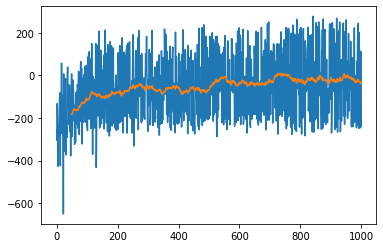

In [57]:
import matplotlib.pyplot as plt
import pandas as pd
plt.plot(history)
plt.plot(pd.Series(history).rolling(50).mean())